# **Predicting Next Day Percent Increase in Bikeshare Rentals**
## **Jaleel Walter Henry Savoy**

The objective of this project is to build a neural network to predict the daily percent increase in bike rentals from the next day for the Capital Bikeshare Program in the Washington, DC area. The data set includes data relating to the rentals themselves, the season, holiday status, and the weather conditions.

First, I built a simple linear regression with L2-regularization to use as a performance baseline, and I then built a 5-layer deep feedforward neural network to account for non-linearities and better fit the true, underlying target function.

The performance of the neural network greatly exceeds the performance of the linear regression with L2-regularization on the validation set, based on the R-squared and the mean-squared error of the models.

Admittedly, the performance of this model is not amazing, but the coefficient of determination is still decent given the problem. 

# **Relevant Links**

Data Description: https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

Capital Bikeshare Site: https://www.capitalbikeshare.com/system-data

Data Directory: https://archive.ics.uci.edu/ml/machine-learning-databases/00275/

Compressed Data: https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip


In [0]:
## Relevant Imports
import numpy as np, pandas as pd, random
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.metrics import explained_variance_score, median_absolute_error, mean_absolute_error, max_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso


import io
import json
import urllib.request
import zipfile

import os, random
os.environ['PYTHONHASHSEED']=str(123)
random.seed(123)
np.random.seed(123)

import pickle
from google.colab import files

In [0]:
# Get the Data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip'
url = urllib.request.urlopen(url)
zippedfile = zipfile.ZipFile(io.BytesIO(url.read()))
data_raw = pd.read_csv(zippedfile.open('day.csv'))

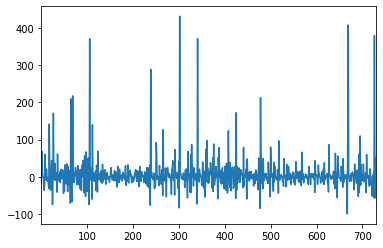

In [3]:
data = data_raw.loc[:, ['season', 'mnth', 'holiday', 'weekday','workingday',
                        'weathersit', 'windspeed', 'temp','cnt']]
data['weathersit_yest'] = data['weathersit'].shift(1)
data['holiday_yest'] = data['holiday'].shift(1)
data['windspeed_yest'] = data['windspeed'].shift(1)
data['temp_yest'] = data['temp'].shift(1)
data['cnt_yest'] = data['cnt'].shift(1)
data['cnt_delta_diff_pct'] = (((data['cnt'].diff(1))/data['cnt_yest'])*100)
data.drop([0], axis=0, inplace=True)
data['z'] = np.abs(stats.zscore(data.cnt_delta_diff_pct))
data = data[data['z'] < 3]
data.cnt_delta_diff_pct.plot()

In [0]:
response = ['cnt_delta_diff_pct']
predictors = data.drop(['cnt', 'cnt_delta_diff_pct', 'z'], axis=1).columns

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data[predictors], data[response],
                                                    test_size=0.20, random_state=123, shuffle=True)

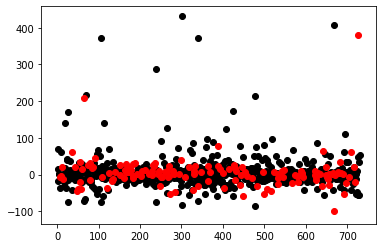

In [6]:
plt.scatter(y_train.index, y_train, c='black')
plt.scatter(y_test.index, y_test, c='red')

In [0]:
lasso_reg_preds = Lasso(alpha=0.1).fit(x_train, y_train).predict(x_test)

In [8]:
print(explained_variance_score(y_test, lasso_reg_preds))
print(r2_score(y_test, lasso_reg_preds))
print(median_absolute_error(y_test, lasso_reg_preds))
print(mean_absolute_error(y_test, lasso_reg_preds))
print(mean_squared_error(y_test, lasso_reg_preds))
print(max_error(y_test, lasso_reg_preds))

0.23734000418582646
0.2365242374914941
12.653547282190067
20.031447181484396
1437.4302644143065
332.2325388439941


In [9]:
import keras
from keras.layers import Dense, Activation, Dropout

from tensorflow import set_random_seed
set_random_seed(123)
 
model = keras.Sequential()
model.add(Dense(1024, input_dim=x_train.shape[1]))
model.add(Dropout(0.05))
model.add(Activation('relu'))
model.add(Dense(1024))
model.add(Dropout(0.05))
model.add(Activation('relu'))
model.add(Dense(1,))

model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              14336     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         


In [10]:
history=model.fit(x_train, y_train, validation_split=0.15, epochs=10000,batch_size=256, verbose=0)

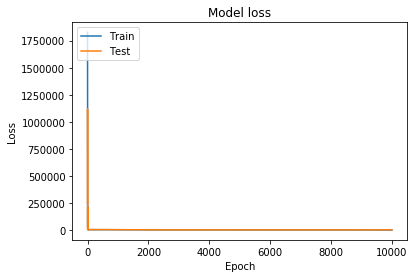

In [11]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
pred_nnet = model.predict(x_test)

print(explained_variance_score(y_test, pred_nnet))
print(r2_score(y_test, pred_nnet))
print(median_absolute_error(y_test, pred_nnet))
print(mean_absolute_error(y_test, pred_nnet))
print(mean_squared_error(y_test, pred_nnet))
print(max_error(y_test, pred_nnet))

0.7580155038681122
0.7448432108062083
9.615396793549529
15.323766306216138
480.39519912572376
83.17393761250511


In [0]:
filename = 'bike_pred_model.sav'
pickle.dump(model, open(filename, 'wb'))
files.download(filename)